# Alternative Visualizations for BloodHound
-----------------------------------------
* **Content Author:** Andy Robbins @_wald0
* **Notebook Author:** Roberto Rodriguez @Cyb3rWard0g
* **Reference:** https://posts.specterops.io/visualizing-bloodhound-data-with-powerbi-part-1-ba8ea4908422

## Import Libraries

In [1]:
from py2neo import Graph
import plotly.graph_objects as go
import altair as alt
alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

## Initialize BloodHound neo4j Database Connection

In [2]:
g = Graph("bolt://206.189.85.93:7687", auth=("neo4j", "BloodHound"))
g

<Graph database=<Database uri='bolt://206.189.85.93:7687' secure=False user_agent='py2neo/4.3.0 neobolt/1.7.15 Python/3.7.3-final-0 (linux)'> name='data'>

## Retrieve Security Groups with Local Admin Rights over Computers

Now we’ll construct the Cypher query that tells us the name of each security group in Active Directory and the number of computers that group has local admin rights on.

In [3]:
sg_computers_df = g.run("""
MATCH (g:Group)
OPTIONAL MATCH (g)-[:AdminTo]->(c1:Computer)
OPTIONAL MATCH (g)-[:MemberOf*1..]->(:Group)-[:AdminTo]->(c2:Computer)
WITH g, COLLECT(c1) + COLLECT(c2) AS tempVar
UNWIND tempVar AS computers
RETURN g.name AS GroupName,COUNT(DISTINCT(computers)) AS AdminRightCount
ORDER BY AdminRightCount DESC
""").to_data_frame()

In [4]:
sg_computers_df

GroupName  AdminRightCount
0    DOMAIN ADMINS@TOKYO.JAPAN.LOCAL                6
1    DESKTOPADMINS@TOKYO.JAPAN.LOCAL                4
2          DOMAIN ADMINS@JAPAN.LOCAL                4
3          MACHINEADMINS@JAPAN.LOCAL                3
4      ENTERPRISE ADMINS@JAPAN.LOCAL                2
5      DOMAIN ADMINS@SINGAPORE.LOCAL                2
6  ENTERPRISE ADMINS@SINGAPORE.LOCAL                1
7  WORKSTATIONADMINS@SINGAPORE.LOCAL                1

## Create Horizontal Bar Chart: Most Privileged Active Directory Security Groups

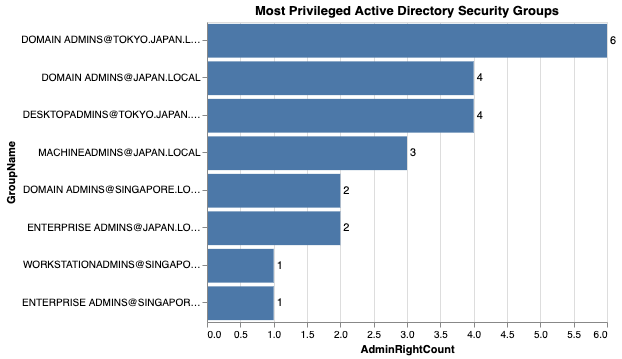

In [5]:
bars = alt.Chart(sg_computers_df, title="Most Privileged Active Directory Security Groups").mark_bar().encode(
    x='AdminRightCount:Q',
    y=alt.Y(
        "GroupName:N",
        sort=alt.EncodingSortField(
            field="AdminRightCount",
            order="descending"
        )
    )
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='AdminRightCount:Q'
)

(bars + text).properties(height=300)

## Create Horizontal Bar Chart: Most Privileged Active Directory Security Groups

In [6]:
users_to_da = g.run("""
MATCH (totalUsers:User {domain:'TOKYO.JAPAN.LOCAL'})
MATCH p=shortestPath((UsersWithPath:User {domain:'TOKYO.JAPAN.LOCAL'})-[r*1..]->(g:Group {name:'DOMAIN ADMINS@TOKYO.JAPAN.LOCAL'}))
WITH COUNT(DISTINCT(totalUsers)) as totalUsers, COUNT(DISTINCT(UsersWithPath)) as UsersWithPath
RETURN 100.0 * UsersWithPath / totalUsers AS percentUsersToDA
""").to_data_frame()

In [7]:
users_to_da

percentUsersToDA
0         13.580247

In [8]:
value_df = users_to_da['percentUsersToDA'].values[0]
value_df

13.580246913580247

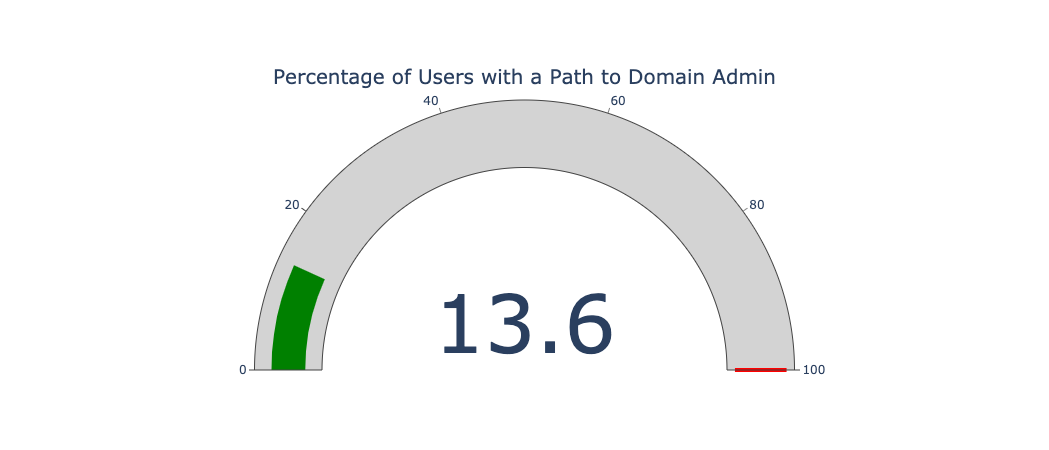

In [9]:
fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = (value_df),
    mode = "gauge+number",
    title = {'text': "Percentage of Users with a Path to Domain Admin"},
    gauge = {'axis': {'range': [None, 100]},
             'steps' : [{'range': [0, 250], 'color': "lightgray"}],
             'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 490}}))

fig.show()
         